# Import and Config

In [1]:
import tensorflow as tf
from discofuzz.constants import SIMILARITY_METRICS

# Import DisCoFuzz package classes
from discofuzz.constants import *
from discofuzz.config import *
from discofuzz.WiCDatasetHandler import WiCDatasetHandler
from discofuzz.BaseEmbeddingModel import BaseEmbeddingModel
from discofuzz.DisCoFuzz import DisCoFuzz
from discofuzz.EvalHarness import EvalHarness

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\igeek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU available: {gpus}")

In [3]:
from sklearn.decomposition import PCA
# Define all available similarity metrics from FourierFuzzifier
sim_metrics_enum = [SIMILARITY_METRICS.COS, SIMILARITY_METRICS.W1, SIMILARITY_METRICS.W2, SIMILARITY_METRICS.Q]
n_components = 2
fuzzification_kernel_size = 8
enrich_lemmas_with_wn = False
full_eval = False

# load config vars or defaults
X_train, y_train, X_test, y_test = WiCDatasetHandler.load_dataset(".")
if not full_eval:
    sample_size = 10
    X_train, y_train, X_test, y_test = (
        X_train[:sample_size],
        y_train[:sample_size],
        # X_train[:sample_size],
        # y_train[:sample_size],
        X_test[:sample_size],
        y_test[:sample_size]
    )
# evaluating space on full, combined training+test set, as fuzzification model is nonparametric
X_test = pd.concat([X_train, X_test])
y_test = pd.concat([y_train, y_test])

sim_metrics = [s.value for s in sim_metrics_enum]
embedding_model = BaseEmbeddingModel(
    dim_reduc=PCA(n_components=n_components)
)
model = DisCoFuzz(
    embedding_model,
    enrich_lemmas_with_wn=enrich_lemmas_with_wn
)
eval_harness = EvalHarness(
    sim_metrics=sim_metrics_enum,
    composition_strategies=STRATEGIES,
    embedding_model=embedding_model,
    spacy_model=model.spacy_model,
    fuzzifier=model.lemma_vectorizer.fuzzifier,
)

# Run model

In [4]:
sents = X_test["sent_1"].to_list() + X_test["sent_2"].to_list()
embedding_model.fit_transform(sents)

array([[ 0.17849763,  0.11003303],
       [-0.2017532 ,  0.14074162],
       [-0.08023898,  0.15799661],
       [ 0.14501174, -0.36188215],
       [ 0.2601497 ,  0.07060561],
       [ 0.12527974,  0.03202094],
       [ 0.40160298, -0.341123  ],
       [ 0.35733935,  0.17714976],
       [ 0.27008486,  0.3670632 ],
       [-0.43675676,  0.08354266],
       [-0.37537876,  0.08492419],
       [ 0.09928436, -0.40034115],
       [ 0.09183498, -0.18093897],
       [-0.12146124,  0.12446172],
       [-0.30450174,  0.04607946],
       [-0.3695978 , -0.27618825],
       [ 0.01607277,  0.14116837],
       [ 0.15864342,  0.30535325],
       [ 0.4080701 ,  0.08721571],
       [-0.16983905,  0.37921622],
       [ 0.2050356 ,  0.04825296],
       [ 0.02216111, -0.07980167],
       [ 0.32309812,  0.14667809],
       [ 0.26158142, -0.17799637],
       [ 0.20505302,  0.02357752],
       [ 0.21021962, -0.18648896],
       [ 0.03699498, -0.5119772 ],
       [-0.16751195,  0.03101376],
       [-0.2524623 ,

In [5]:
X_test = model.fit(X_test)
X_test = model.predict_batch(X_test, STRATEGIES)

	Composing embeddings with mean approach...
	Composing embeddings with intersection+mean approach...
	Composing embeddings with intersection+union approach...
	Composing embeddings with intersection+intersection approach...
	Composing embeddings with selective_intersection+mean approach...
	Composing embeddings with selective_intersection+union approach...
	Composing embeddings with selective_intersection+intersection+mean approach...


# Evaluate models

In [6]:
eval_harness.fit(X_test)
sims_df = eval_harness.get_similarities(X_test)
sims_df.head()

(20, 2)
(20, 2)

	=== Computing similarities with cos metric ===
		Getting compositional embedding relatedness scores for baseline_sent approach...
		Getting compositional embedding relatedness scores for baseline_tok approach...
		Getting compositional embedding relatedness scores for intersection+intersection approach...
		Getting compositional embedding relatedness scores for intersection+mean approach...
		Getting compositional embedding relatedness scores for intersection+union approach...
		Getting compositional embedding relatedness scores for mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+mean approach...
		Getting compositional embedding relatedness scores for selective_intersection+union approach...

	=== Computing similarities with wasserstein-1 metric ===
		Getting compositional embedding relatedness scores for basel

,baseline_sent_cos_sim_components=0,baseline_sent_cos_sim_components=1,baseline_tok_cos_sim_components=0,baseline_tok_cos_sim_components=1,fuzzy_baseline_sent_cos_sim_components=0,fuzzy_baseline_sent_cos_sim_components=1,fuzzy_baseline_tok_cos_sim_components=0,fuzzy_baseline_tok_cos_sim_components=1,fuzzy_intersection+intersection_cos_sim_components=0,fuzzy_intersection+intersection_cos_sim_components=1,...,fuzzy_intersection+union_quantum_sim_components=0,fuzzy_intersection+union_quantum_sim_components=1,fuzzy_mean_quantum_sim_components=0,fuzzy_mean_quantum_sim_components=1,fuzzy_selective_intersection+intersection+mean_quantum_sim_components=0,fuzzy_selective_intersection+intersection+mean_quantum_sim_components=1,fuzzy_selective_intersection+mean_quantum_sim_components=0,fuzzy_selective_intersection+mean_quantum_sim_components=1,fuzzy_selective_intersection+union_quantum_sim_components=0,fuzzy_selective_intersection+union_quantum_sim_components=1
0,0.4,0.271492,0.1,0.163480,0.165747,0.207208,0.055790,-0.073022,-0.072601,-0.177272,...,0.210932,0.254249,0.059757,0.062793,0.061780,0.080319,0.061780,0.080319,0.198741,0.199184
1,-0.6,-0.683790,0.1,-0.067216,0.047152,-0.476975,-0.054055,-0.134337,-0.074676,0.124748,...,0.210941,0.254253,0.057242,0.058274,0.061719,0.080258,0.061719,0.080258,0.198752,0.199189
2,-0.6,-0.279920,0.1,-0.192951,-0.005406,-0.159070,-0.429732,-0.170651,0.262325,-0.274859,...,-0.259993,-0.249724,-0.089727,-0.086528,0.043119,0.061658,0.043119,0.061658,0.198527,0.198981
3,0.4,0.205325,0.1,0.109652,0.197361,0.523025,0.009634,0.013421,-0.093933,-0.053389,...,0.210943,0.254262,0.048969,0.052174,-0.002637,0.015901,-0.002637,0.015901,0.198755,0.199191
4,0.4,0.293636,0.1,0.161005,0.176304,0.208090,0.061371,-0.071337,0.050891,0.175278,...,0.210917,0.254247,0.059246,0.062456,-0.025362,-0.015595,-0.025362,-0.015595,-0.785989,-0.792889


In [7]:
sim_eval_df = eval_harness.classify_similarities(sims_df)

# Visualizations

## Custom similarities vs cosine similarity in original space

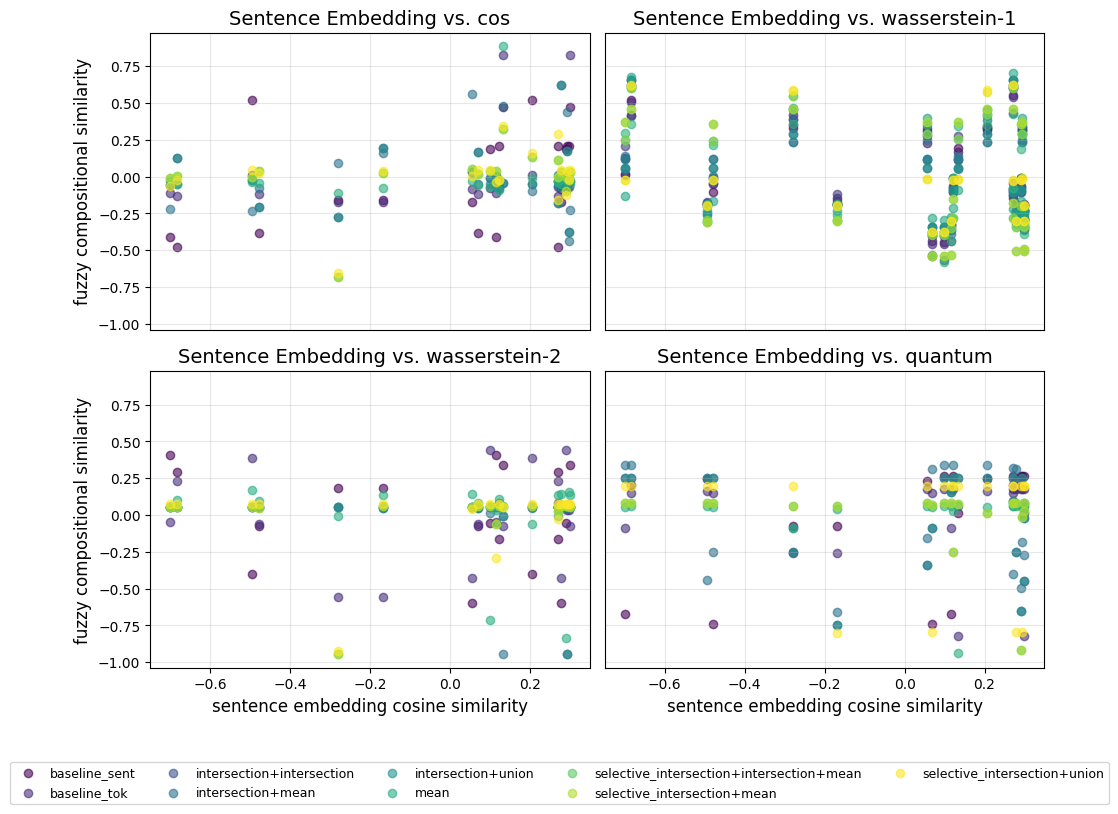

In [8]:
eval_harness.visualize_similarities(sims_df, dimensionality=n_components)

## Confusion Matrices

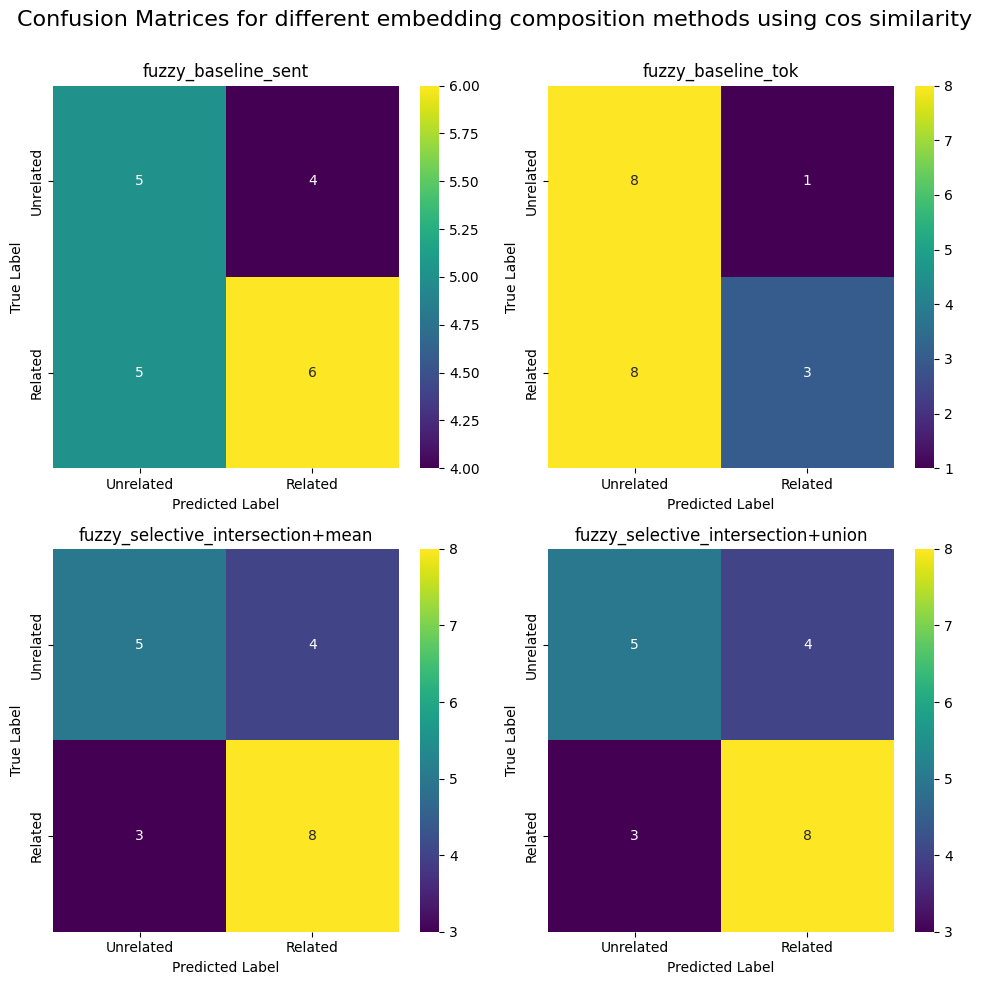

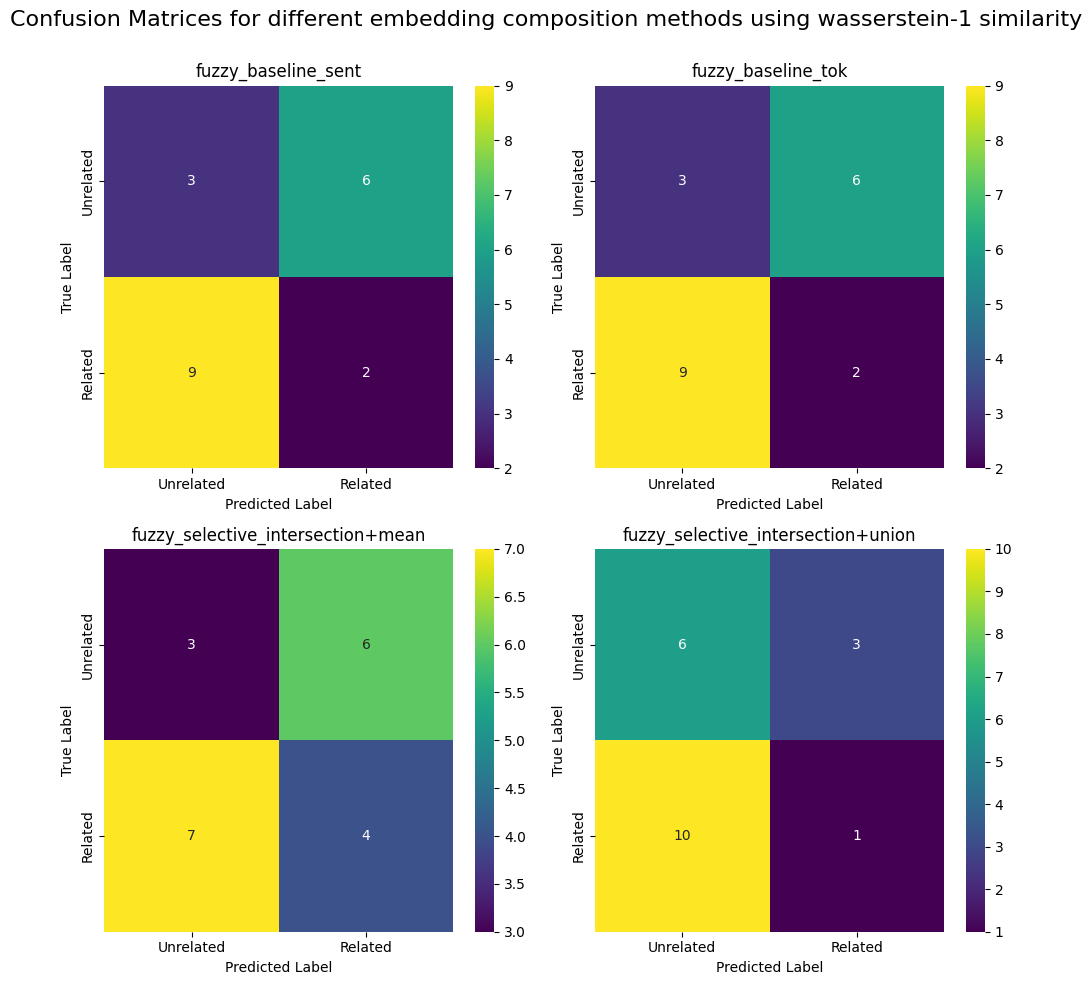

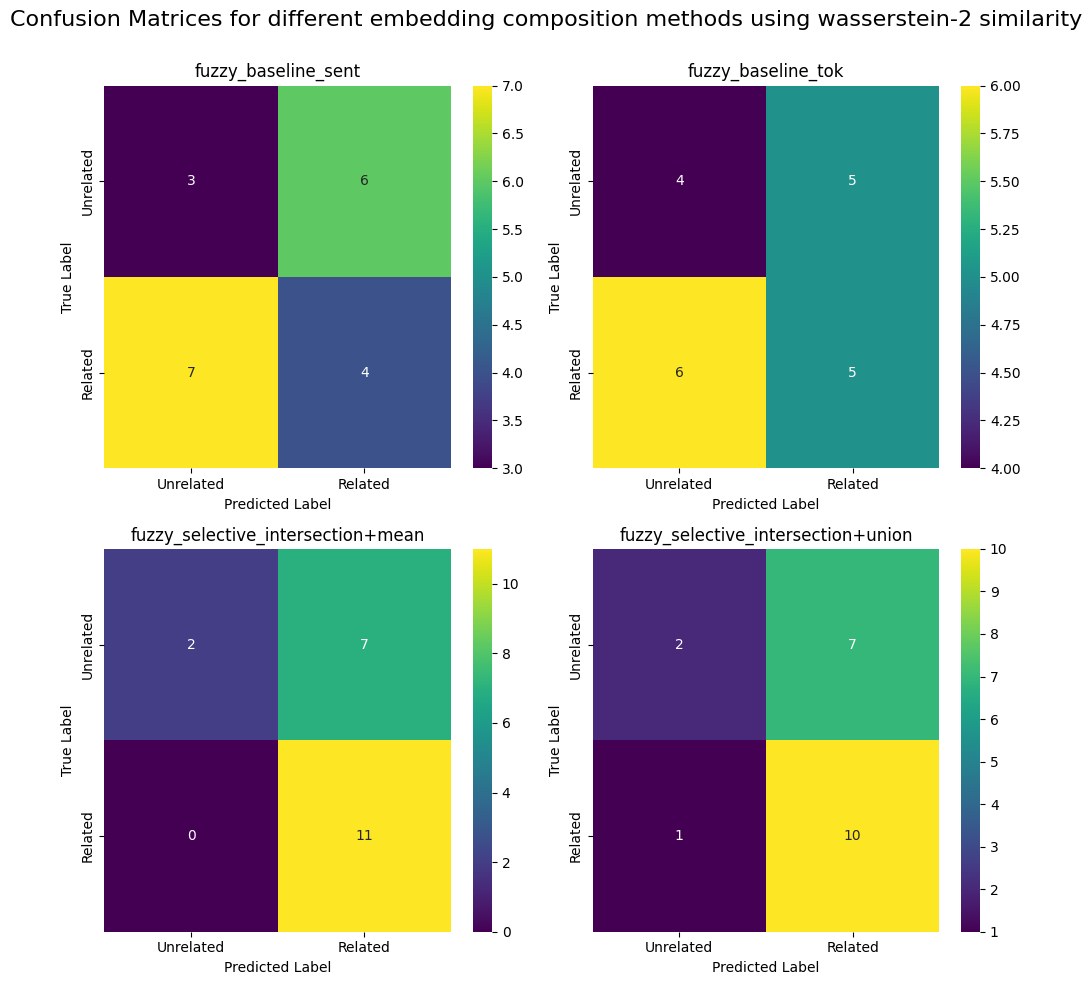

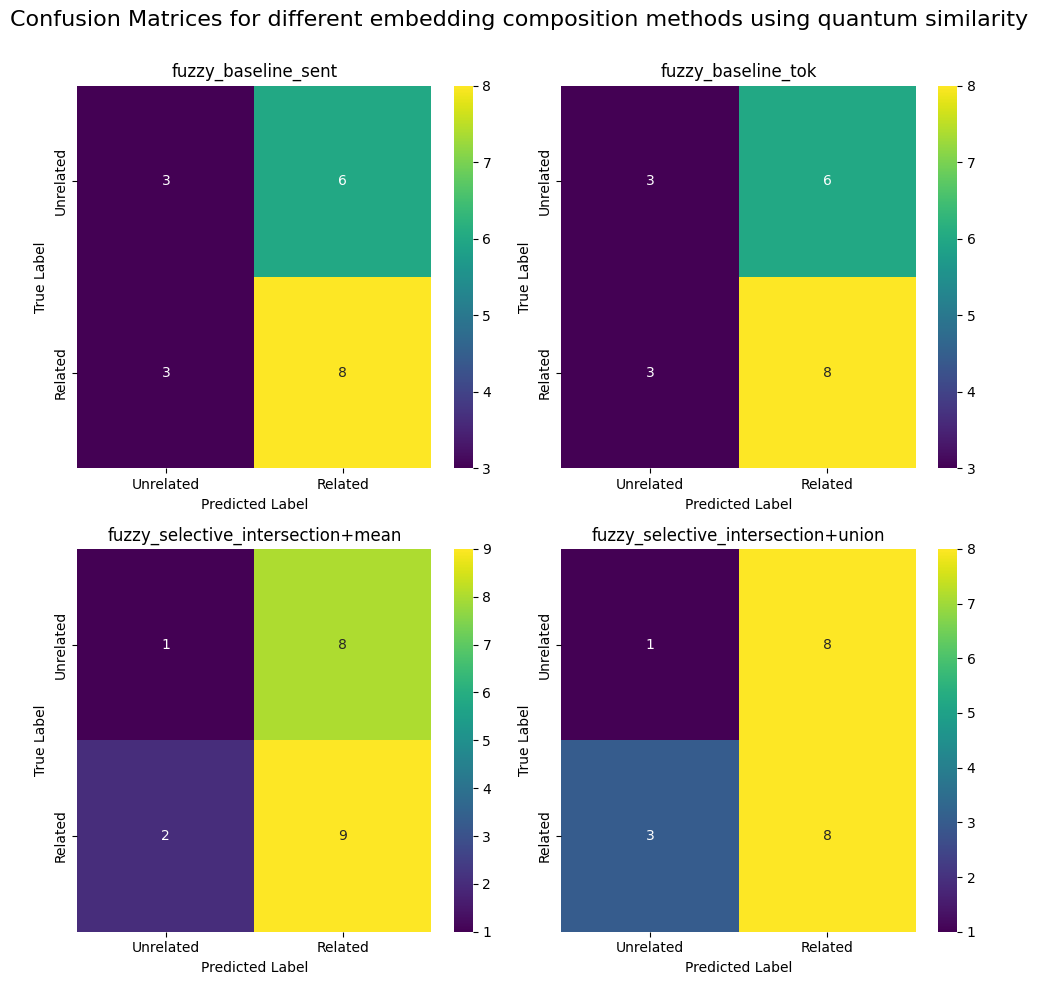

In [9]:
models = [
    "baseline_sent",
    "baseline_tok",
    "selective_intersection+mean",
    "selective_intersection+union",
]
metric_cols = []
for sim_metric in sim_metrics:
    metric_cols.extend([
        f"{fmt_dim_reduc_sim_col(f'fuzzy_{model}_{sim_metric}', n_components-1)}_pred"
        for model in models
    ])
eval_harness.plot_confusion_matrices(
    X=sim_eval_df[metric_cols],
    y=y_test,
    dimensionality=n_components
)

# Evaluation Results

In [10]:
sim_eval_df.head()

,baseline_sent_cos_sim_components=0_pred,baseline_sent_cos_sim_components=1_pred,baseline_tok_cos_sim_components=0_pred,baseline_tok_cos_sim_components=1_pred,fuzzy_baseline_sent_cos_sim_components=0_pred,fuzzy_baseline_sent_cos_sim_components=1_pred,fuzzy_baseline_tok_cos_sim_components=0_pred,fuzzy_baseline_tok_cos_sim_components=1_pred,fuzzy_intersection+intersection_cos_sim_components=0_pred,fuzzy_intersection+intersection_cos_sim_components=1_pred,...,fuzzy_intersection+union_quantum_sim_components=0_pred,fuzzy_intersection+union_quantum_sim_components=1_pred,fuzzy_mean_quantum_sim_components=0_pred,fuzzy_mean_quantum_sim_components=1_pred,fuzzy_selective_intersection+intersection+mean_quantum_sim_components=0_pred,fuzzy_selective_intersection+intersection+mean_quantum_sim_components=1_pred,fuzzy_selective_intersection+mean_quantum_sim_components=0_pred,fuzzy_selective_intersection+mean_quantum_sim_components=1_pred,fuzzy_selective_intersection+union_quantum_sim_components=0_pred,fuzzy_selective_intersection+union_quantum_sim_components=1_pred
0,True,True,True,True,True,True,True,False,False,False,...,True,True,True,True,True,True,True,True,True,True
1,False,False,True,False,True,False,False,False,False,True,...,True,True,True,True,True,True,True,True,True,True
2,False,False,True,False,False,False,False,False,True,False,...,False,False,False,False,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,False,False,...,True,True,True,True,False,True,False,True,True,True
4,True,True,True,True,True,True,True,False,True,True,...,True,True,True,True,False,False,False,False,False,False


In [11]:
scores_df = eval_harness.score(sim_eval_df, y_test)
scores_df[:5]

,fuzzy,strategy,similarity_metric,n_components,model,accuracy,precision,recall,f1_score
0,True,selective_intersection+intersection+mean,wasserstein-2,1,selective_intersection+intersection+mean_wasse...,0.65,0.611111,1.0,0.758621
1,True,selective_intersection+mean,wasserstein-2,1,selective_intersection+mean_wasserstein-2,0.65,0.611111,1.0,0.758621
2,True,intersection+intersection,wasserstein-2,0,intersection+intersection_wasserstein-2,0.60,0.578947,1.0,0.733333
3,True,intersection+union,wasserstein-2,0,intersection+union_wasserstein-2,0.60,0.578947,1.0,0.733333
4,True,selective_intersection+intersection+mean,wasserstein-2,0,selective_intersection+intersection+mean_wasse...,0.60,0.578947,1.0,0.733333


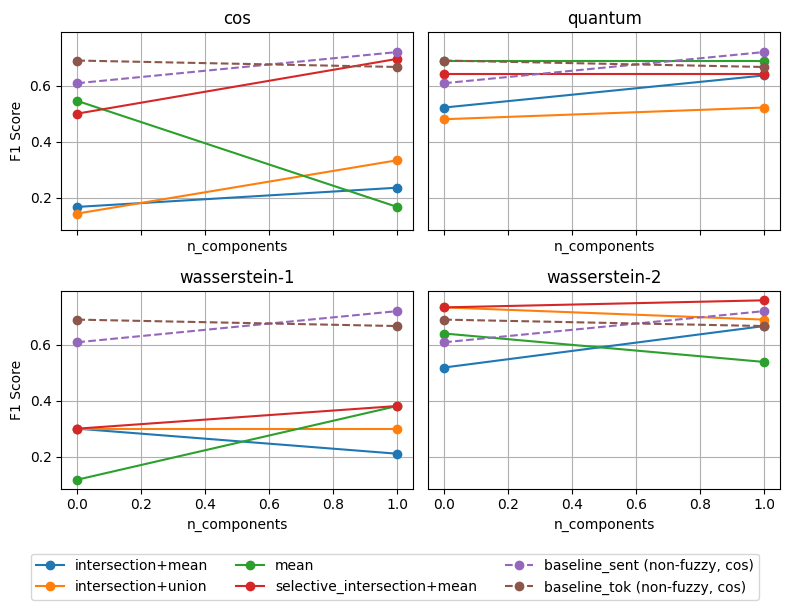

In [12]:
strategies_to_plot = [
    "mean",
    "intersection+mean",
    "intersection+union",
    "selective_intersection+mean"
]

eval_harness.visualize_f1_by_metric_n_components(scores_df, strategies=strategies_to_plot)

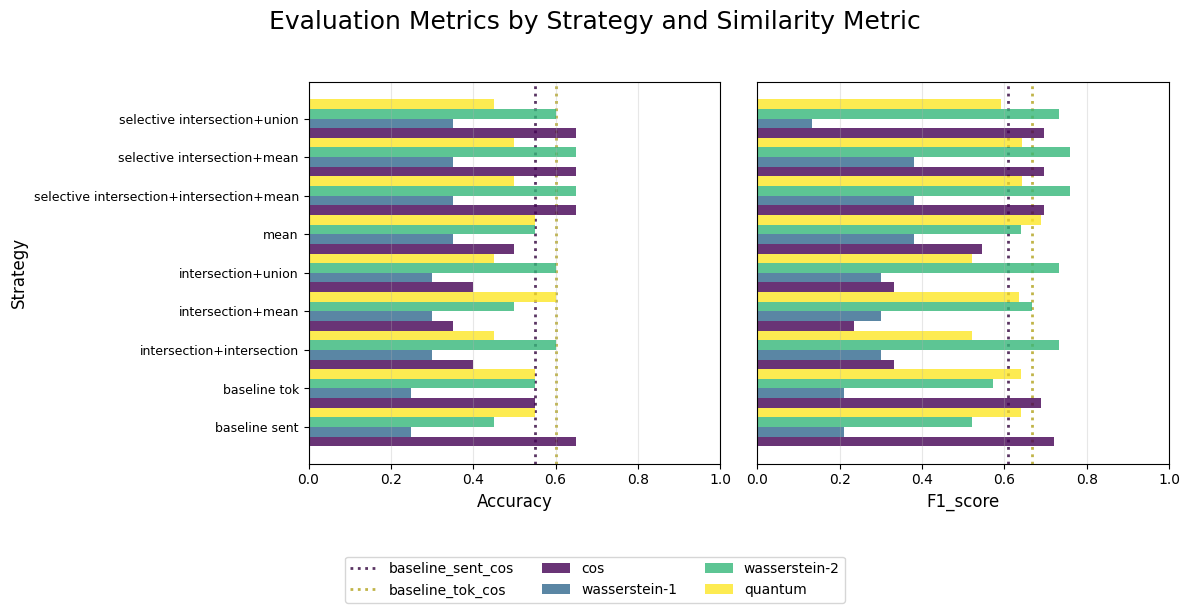

In [13]:
eval_harness.visualize_scores(scores_df, n_components)

In [14]:
scores_df.to_csv(f"full_eval={full_eval},wn_enriched={enrich_lemmas_with_wn},n_components={n_components},kernel_size={fuzzification_kernel_size}.tsv", sep="\t")